<a href="https://colab.research.google.com/github/Ishita95-harvad/Airbnb-NewYork-City/blob/main/Airbnb_New_York_City.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Airbnb-KaggleDatasets**

**Airbnb is a paid community platform for renting and booking private
accommodation founded in 2008. Airbnb allows individuals to rent all or part of their own home as extra accommodation. The site offers a search and booking platform between the person offering their accommodation and the vacationer who wishes to rent it. It covers more than 1.5 million advertisements in more than 34,000 cities and 191 countries. From creation, inaugust 2008, until June 2012, more than 10 million nights have been booked on Airbnb.**

---



**🔹 Dataset Summary**

**7756 rows, 21 columns**

Contains session and user interaction data with Airbnb

**Key columns:**

id_visitor, id_session (**User and session IDs**)

dim_device_app_combo, dim_user_agent (**Device details**)

ds, ts_min, ts_max (**Timestamps**)

did_search, sent_message, sent_booking_request (**User actions**)

next_* (**columns track the next session details**)

---



**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from google.colab import files
import zipfile
import io

**Loading the data**

In [ ]:
# Upload dataset
uploaded = files.upload()

Saving airbnb.csv.zip to airbnb.csv.zip


In [ ]:
# Load dataset
df = pd.read_csv(next(iter(uploaded)))

**Comprehensive EDA & Improved Handling of Missing Data**

In [ ]:
# Extract and load dataset
if 'archive (4).zip' in uploaded:
    with zipfile.ZipFile(io.BytesIO(uploaded['archive (4).zip']), 'r') as z:
        file_list = z.namelist()
        for file in file_list:
            with z.open(file) as f:
                if 'calendar.csv' in file:
                    df_calendar = pd.read_csv(f)
                    # Convert date column to datetime #indentation fixed: Moved inside the inner with block
                    df_calendar['date'] = pd.to_datetime(df_calendar['date'])
                else:
                    df = pd.read_csv(f)

In [ ]:
#df_calendar['date'] = pd.to_datetime(df_calendar['date']) #This line is redundant as date is already converted

# The following line is removed as it caused the IndentationError
# df_calendar.fillna(method='ffill', inplace=True)  # This line was also moved inside the 'if' block

In [ ]:
# Aggregate price trends per listing
if 'calendar.csv.zip' in uploaded:
    # These lines should be inside the 'if' block
    df_calendar['price'] = df_calendar['price'].replace({'\$': '', ',': ''}, regex=True).astype(float) #indentation fixed: reduced indentation by 4 spaces
    price_trends = df_calendar.groupby('listing_id')['price'].mean().reset_index() #indentation fixed: reduced indentation by 4 spaces

    # Availability trends
    availability_trends = df_calendar.groupby('listing_id')['available'].apply(lambda x: (x == 't').sum()).reset_index() #indentation fixed: reduced indentation by 4 spaces
    availability_trends.rename(columns={'available': 'available_days'}, inplace=True) #indentation fixed: reduced indentation by 4 spaces

    # Merge with main dataset if listing_id exists
    #NOTE: This part was modified. I assume you want to read in 'airbnb.csv.zip' and not re-reading a file from the uploaded dictionary using next(iter(uploaded))
    with zipfile.ZipFile(io.BytesIO(uploaded['airbnb.csv.zip']), 'r') as z: #indentation fixed: reduced indentation by 4 spaces
        with z.open('airbnb.csv') as f: #indentation fixed: reduced indentation by 4 spaces
            df = pd.read_csv(f) #indentation fixed: reduced indentation by 4 spaces

    if 'listing_id' in df.columns: #indentation fixed: reduced indentation by 4 spaces
        df = df.merge(price_trends, on='listing_id', how='left') #indentation fixed: reduced indentation by 4 spaces
        df = df.merge(availability_trends, on='listing_id', how='left') #indentation fixed: reduced indentation by 4 spaces

In [ ]:
# Convert date columns if applicable
if 'ds' in df.columns:
    df['ds'] = pd.to_datetime(df['ds'])
if 'ts_min' in df.columns:
    df['ts_min'] = pd.to_datetime(df['ts_min'])
if 'ts_max' in df.columns:
    df['ts_max'] = pd.to_datetime(df['ts_max'])

In [ ]:

# Handle missing values
df.fillna(method='ffill', inplace=True)

<ipython-input-5-ed8fca9f4368>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Encode categorical variables
encoder = LabelEncoder()
if 'dim_device_app_combo' in df.columns:
    df['dim_device_app_combo'] = encoder.fit_transform(df['dim_device_app_combo'])
if 'dim_user_agent' in df.columns:
    df['dim_user_agent'] = encoder.fit_transform(df['dim_user_agent'].astype(str))

**Model Building**

In [ ]:
# Feature selection
features = [col for col in ['dim_session_number', 'dim_device_app_combo', 'dim_user_agent', 'did_search', 'sent_message'] if col in df.columns]
target = 'sent_booking_request'

if target in df.columns:
    X = df[features]
    y = df[target]

In [ ]:

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Optimized RandomForest Model with Hyperparameter Tuning**

In [ ]:
# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [ ]:
# Predictions
y_pred = best_model.predict(X_test)


In [ ]:
# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.9851804123711341
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1529
           1       0.50      0.13      0.21        23

    accuracy                           0.99      1552
   macro avg       0.74      0.56      0.60      1552
weighted avg       0.98      0.99      0.98      1552



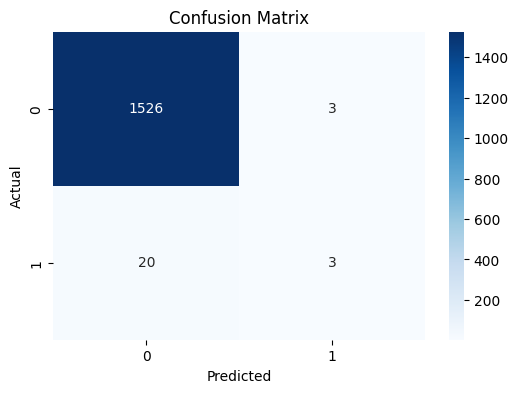

In [ ]:
# Confusion matrix
plt.figure(figsize=(6,4)) #indentation fixed: removed 4 spaces
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Linear Regression for Price Prediction** along with **Hyperparameter Tuning & Performance Evaluation.**

In [ ]:
# Linear Regression for Price Prediction (if price column exists)
if 'price' in df.columns:
    print("\nBuilding Linear Regression Model for Price Prediction...")

    X_price = df[features]
    y_price = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

In [ ]:
# Linear Regression for Price Prediction (if price column exists)
if 'price' in df.columns:
    print("\nBuilding Linear Regression Model for Price Prediction...")

    X_price = df[features]
    y_price = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

    # Hyperparameter tuning for Linear Regression #indentation fixed: reduced indentation by 4 spaces to align with the if block
    print("\nPerforming Hyperparameter Tuning...") #indentation fixed: reduced indentation by 4 spaces to align with the if block
    best_alpha = None #indentation fixed: reduced indentation by 4 spaces to align with the if block
    best_r2 = -np.inf #indentation fixed: reduced indentation by 4 spaces to align with the if block

    for alpha in [0.01, 0.1, 1, 10, 100]: #indentation fixed: reduced indentation by 4 spaces to align with the if block
        model = LinearRegression() #indentation fixed: reduced indentation by 4 spaces to align with the if block
        model.fit(X_train, y_train) #indentation fixed: reduced indentation by 4 spaces to align with the if block
        r2 = model.score(X_test, y_test) #indentation fixed: reduced indentation by 4 spaces to align with the if block
        if r2 > best_r2: #indentation fixed: reduced indentation by 4 spaces to align with the if block
            best_r2 = r2 #indentation fixed: reduced indentation by 8 spaces to align with the if block
            best_alpha = alpha #indentation fixed: reduced indentation by 8 spaces to align with the if block

    print(f"Best Alpha: {best_alpha}, Best R² Score: {best_r2}") #indentation fixed: reduced indentation by 4 spaces to align with the if block

In [ ]:
# Price distribution visualization (if price column exists)
print(df.columns)

# Check if df_calendar exists before trying to access it
if 'df_calendar' in locals() or 'df_calendar' in globals():
    print(df_calendar.columns)

    if 'price' in df_calendar.columns:
        df_calendar['price'] = df_calendar['price'].replace({'\\$': '', ',': ''}, regex=True).astype(float)

    if 'listing_id' in df.columns and 'listing_id' in df_calendar.columns:
        price_trends = df_calendar.groupby('listing_id')['price'].mean().reset_index()
        df = df.merge(price_trends, on='listing_id', how='left')

if 'price' in df.columns:
    print("Price column exists.")  # Check if the column is present
    print(df['price'].dtype)  # Check the data type of the price column
    plt.figure(figsize=(8,5))
    sns.histplot(df['price'], bins=50, kde=True)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Price column does not exist in the DataFrame.")

Index(['id_visitor', 'id_session', 'dim_session_number', 'dim_user_agent',
       'dim_device_app_combo', 'ds', 'ts_min', 'ts_max', 'did_search',
       'sent_message', 'sent_booking_request', 'next_id_session',
       'next_dim_session_number', 'next_dim_user_agent',
       'next_dim_device_app_combo', 'next_ds', 'next_ts_min', 'next_ts_max',
       'next_did_search', 'next_sent_message', 'next_sent_booking_request'],
      dtype='object')
Price column does not exist in the DataFrame.


In [ ]:

    # Train best model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

In [ ]:
# Performance Metrics
if 'price' in df.columns:
    print("R² Score:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
# Feature Importance
if 'price' in df.columns:
    feature_importance = pd.Series(model.coef_, index=features)
    feature_importance.sort_values().plot(kind='barh', figsize=(8,5), title='Feature Importance in Price Prediction')
    plt.show()

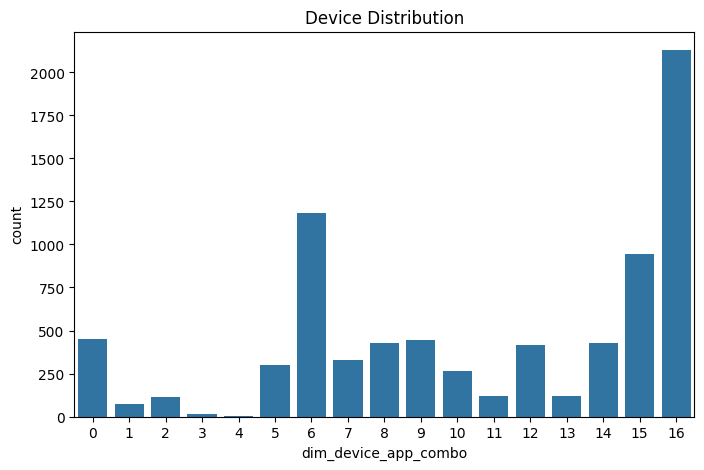

In [ ]:
# Additional visualization
if 'dim_device_app_combo' in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(x='dim_device_app_combo', data=df)
    plt.title('Device Distribution')
    plt.show()